# Define a HEALPix parent “chunk” footprint for a ROMS subdomain

This notebook derives a **coarser HEALPix “parent chunk” footprint** from a Region Of Interest (ROI) that is already represented on a **HEALPix nested grid**.  
The resulting footprint can be used to **summarize / tile** the ROI at a chosen parent depth and to **overlay** that footprint on the original ROMS field in lon/lat for validation.

## Workflow

1. **Load ROI already expressed in HEALPix cell IDs** (nested indexing).
2. **Select a parent depth** and compute parent IDs with `healpix_geo.nested.zoom_to(...)`.
   - In this notebook I tested parent depths **9** and **10**, and finally chose **10** as a good compromise.
3. **Build polygon geometries** for the parent cells using `healpix_geo.nested.vertices(..., ellipsoid="WGS84")`, then union them into a single footprint polygon.
4. **Plot and validate**: overlay the footprint boundary on a ROMS variable (e.g., salinity) on its curvilinear lon/lat grid (`nav_lon_rho`, `nav_lat_rho`).

## Notes

- Geometry is handled in geographic lon/lat; `healpix_geo` calls use the **WGS84 ellipsoid**.
- If longitudes appear in a 0–360 convention, we wrap to **[-180, 180]** for plotting.

## Next step
Next step is to go back to prep_regrid.ipynb, chose this parent cell id's area (and may be one level 13 healpix neighbour area ??
as regridding mapping 


In [1]:
import xarray as xr
import numpy as np
import healpix_geo


## Step 1 — Load the HEALPix ROI

Load the dataset containing the ROI already expressed as **HEALPix cell IDs** (nested).


In [2]:
xr.open_zarr('hp.zarr')

<xarray.Dataset> Size: 4MB
Dimensions:       (time_counter: 2, s_rho: 40, cell_ids: 3303)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 16B 2023-12-01T00:48:10 2023-...
    time_instant  (time_counter) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * cell_ids      (cell_ids) int64 26kB 224374613 224374614 ... 225780866
Data variables:
    salt          (time_counter, s_rho, cell_ids) float64 2MB dask.array<chunksize=(1, 40, 3303), meta=np.ndarray>
    temp          (time_counter, s_rho, cell_ids) float64 2MB dask.array<chunksize=(1, 40, 3303), meta=np.ndarray>
    zeta          (time_counter, cell_ids) float64 53kB dask.array<chunksize=(1, 3303), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [3]:
ds_hp=xr.open_zarr('hp.zarr')

## experiment the parent cell size

First it load region of interest already in healpix grid. 
Then select parent cell id (here I experimented cell id 9 and 10 , and in the end I chose 10. 
The model will have 20 years of time series (data store in hourly) having small enough chunk size on cell_id is requried to make analysis  

## Step 2 — Compute parent cell IDs

Convert ROI cell IDs at depth `D` into **parent IDs** at a coarser depth `parent_depth` using `healpix_geo.nested.zoom_to(...)`.

In this notebook, I compared `parent_depth = 9` vs `10` and selected **10**.


In [4]:
ipix = ds_hp["cell_ids"].values.astype(np.uint64)

depth = 13
parent_depth = 10
parents = healpix_geo.nested.zoom_to(ipix, depth=depth, new_depth=parent_depth)

uniq_parents, counts = np.unique(parents, return_counts=True)
counts, counts.size

(array([36, 36, 64, 36, 34, 33, 13, 61, 64, 15, 46, 13, 63, 58, 64, 28, 18,
        21, 13, 22, 36, 21, 64, 36, 36, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 61, 24, 64, 24, 64, 24, 64, 17, 64, 64, 64, 64, 64, 61,
        11, 42, 64, 64, 64, 49, 36,  3, 64, 57, 64, 52, 12, 22, 11,  3, 33,
        14,  5,  3, 16, 64, 16, 49,  5,  3, 49,  3,  3]),
 80)

In [5]:
hourly_Mbytes=ds_hp.salt.nbytes/2/1024/1024
total_Mbytes=hourly_Mbytes*24*356*20
print('chunk size of 3D value will be ',total_Mbytes/counts.size/(20*356))

chunk size of 3D value will be  0.302398681640625


## Step 3 — Build the parent-cell footprint polygon

Compute parent-cell vertices with `healpix_geo.nested.vertices(...)`, convert to polygons, then merge them into a single footprint using a union operation.


[[46.9456341  46.9947481  47.04385339 46.9947481 ]
 [46.9456341  46.9947481  47.04385339 46.9947481 ]
 [46.9947481  47.04385339 47.09295001 47.04385339]
 [46.9456341  46.9947481  47.04385339 46.9947481 ]
 [46.9947481  47.04385339 47.09295001 47.04385339]
 [46.9456341  46.9947481  47.04385339 46.9947481 ]
 [46.9456341  46.9947481  47.04385339 46.9947481 ]
 [46.9947481  47.04385339 47.09295001 47.04385339]
 [46.9947481  47.04385339 47.09295001 47.04385339]
 [47.04385339 47.09295001 47.14203795 47.09295001]
 [47.04385339 47.09295001 47.14203795 47.09295001]
 [47.09295001 47.14203795 47.19111724 47.14203795]
 [46.9947481  47.04385339 47.09295001 47.04385339]
 [47.04385339 47.09295001 47.14203795 47.09295001]
 [47.04385339 47.09295001 47.14203795 47.09295001]
 [47.09295001 47.14203795 47.19111724 47.14203795]
 [47.09295001 47.14203795 47.19111724 47.14203795]
 [47.14203795 47.19111724 47.24018788 47.19111724]
 [47.14203795 47.19111724 47.24018788 47.19111724]
 [47.19111724 47.24018788 47.28

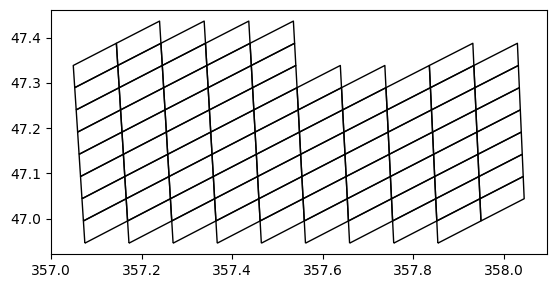

In [19]:
import numpy as np
import healpix_geo
from shapely.geometry import Polygon
import geopandas as gpd

parents = uniq_parents.astype(np.uint64)

# vertices from healpix-geo
# Depending on your version, this returns either:
#   (lonv, latv)  OR  an array shaped (..., 2)
verts = healpix_geo.nested.vertices(parents, depth=parent_depth, ellipsoid="WGS84")

# --- normalize output to lonv, latv with shape (N, Nv) ---
if isinstance(verts, tuple) and len(verts) == 2:
    lonv, latv = verts
    print(latv)
else:
    verts = np.asarray(verts)
    # assume (..., 2) with last dim (lon,lat)
    lonv, latv = verts[..., 0], verts[..., 1]
    print(b)

lonv = np.asarray(lonv, dtype=np.float64)
latv = np.asarray(latv, dtype=np.float64)

# ensure 2D: (N, Nv)
if lonv.ndim == 1:
    lonv = lonv[None, :]
    latv = latv[None, :]

def _unwrap_dateline(lons):
    """Unwrap longitudes so polygons don't zigzag across the dateline."""
    lons = lons.copy()
    if (lons.max() - lons.min()) > 180:
        lons[lons < 0] += 360
    return lons

polys = []
for i in range(lonv.shape[0]):
    xs = _unwrap_dateline(lonv[i])
    ys = latv[i]
    # close polygon
    coords = list(zip(xs, ys))
    if coords[0] != coords[-1]:
        coords.append(coords[0])
    polys.append(Polygon(coords))

gdf = gpd.GeoDataFrame(
    {"parent_id": parents.astype(np.int64)},
    geometry=polys,
    crs="EPSG:4326",
)

ax = gdf.plot(edgecolor="k", facecolor="none")
ax.set_aspect("equal")



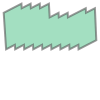

In [7]:
from shapely.ops import unary_union

footprint = unary_union(gdf.geometry)   # MultiPolygon or Polygon
footprint

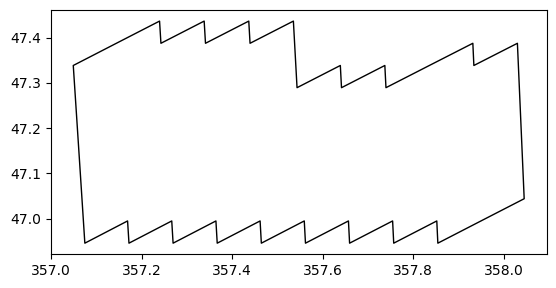

In [8]:
import geopandas as gpd

gdf_fp = gpd.GeoDataFrame(geometry=[footprint], crs="EPSG:4326")

ax = gdf_fp.plot(edgecolor="k", facecolor="none")
ax.set_aspect("equal")

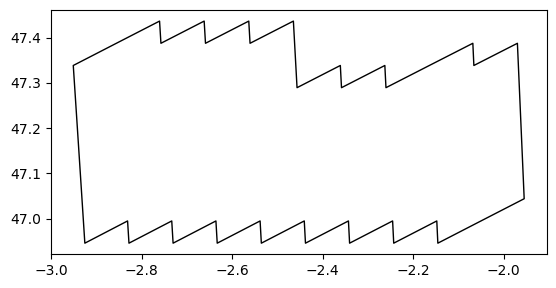

In [9]:
from shapely.ops import transform

def wrap_lon_180(x, y, z=None):
    x = ((x + 180) % 360) - 180
    return (x, y) if z is None else (x, y, z)

footprint_180 = transform(wrap_lon_180, footprint)

gdf_fp180 = gpd.GeoDataFrame(geometry=[footprint_180], crs="EPSG:4326")
ax = gdf_fp180.plot(edgecolor="k", facecolor="none")
ax.set_aspect("equal")

## Step 4 — Overlay footprint on ROMS field

Plot a ROMS variable (e.g., salinity) using its curvilinear lon/lat coordinates (`nav_lon_rho`, `nav_lat_rho`), and overlay the footprint boundary for visual validation.


In [10]:
salt2d=xr.open_zarr('/Users/todaka/data/RIOMAR/small_withtime.zarr')["salt"].isel(time_counter=0, s_rho=0)
lon2d=xr.open_zarr('/Users/todaka/data/RIOMAR/small_withtime.zarr')["nav_lon_rho"]
lat2d=xr.open_zarr('/Users/todaka/data/RIOMAR/small_withtime.zarr')["nav_lat_rho"]




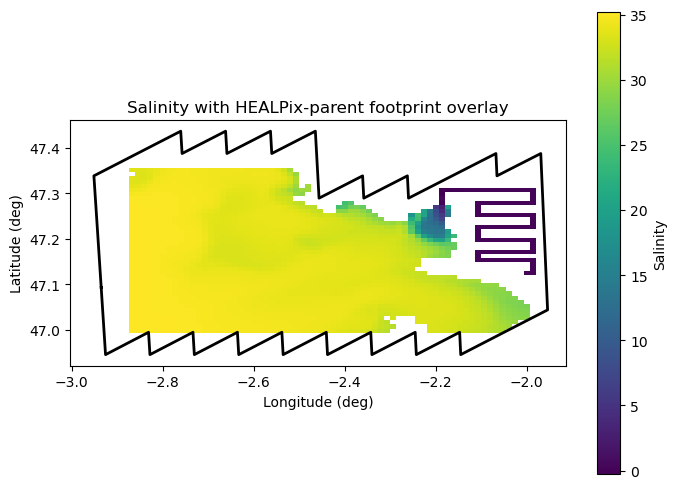

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))

# salinity background (works for curvilinear grids)
m = ax.pcolormesh(lon2d, lat2d, salt2d, shading="auto")
plt.colorbar(m, ax=ax, label="Salinity")

# overlay footprint (Polygon or MultiPolygon)
def plot_geom_outline(ax, geom, **kw):
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        ax.plot(x, y, **kw)
    elif geom.geom_type == "MultiPolygon":
        for g in geom.geoms:
            x, y = g.exterior.xy
            ax.plot(x, y, **kw)
    else:
        # fallback for GeometryCollection etc.
        try:
            for g in geom.geoms:
                plot_geom_outline(ax, g, **kw)
        except Exception:
            pass

plot_geom_outline(ax, footprint_180, color="k", linewidth=2)

ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.set_aspect("equal", adjustable="box")
ax.set_title("Salinity with HEALPix-parent footprint overlay")
plt.show()

In [13]:
healpix_geo.nested.zoom_to(parents, depth=parent_depth, new_depth=depth)

array([[224374592, 224374593, 224374594, ..., 224374653, 224374654,
        224374655],
       [224374656, 224374657, 224374658, ..., 224374717, 224374718,
        224374719],
       [224374720, 224374721, 224374722, ..., 224374781, 224374782,
        224374783],
       ...,
       [225780736, 225780737, 225780738, ..., 225780797, 225780798,
        225780799],
       [225780800, 225780801, 225780802, ..., 225780861, 225780862,
        225780863],
       [225780864, 225780865, 225780866, ..., 225780925, 225780926,
        225780927]], shape=(80, 64), dtype=uint64)